In [1]:
import tensorflow as tf
import tensorboard
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras.layers as nn
import os
from zipfile import ZipFile
import pickle
import datetime


In [2]:
if len(os.listdir("data/")) == 0:
    ZipFile("brain-tumor-classification-mri-images.zip").extractall("data/")

IMG_SIZE = 224
batch_size = 32
class_name = ["Meningioma", "Glioma", "Pitutary"]

image_label = np.array(pickle.load(open('data/brain_tumor_mri/new_dataset/labels.pickle','rb'))) - 1
total_imgs = len(image_label)


In [3]:
file_path = []
for i in os.listdir('data/brain_tumor_mri/new_dataset/bt_images/'):
    file_path.append('data/brain_tumor_mri/new_dataset/bt_images/' + i)

dataset = tf.data.Dataset.from_tensor_slices((file_path, image_label))

def ds_split(ds, train_split, validation_split, total_images):
    train_imgs = int(total_images*train_split)
    val_imgs = int(total_images*validation_split)
    ds.shuffle(total_images)

    train_ds = ds.take(train_imgs)
    ds = ds.skip(train_imgs)
    val_ds = ds.take(val_imgs)
    ds = ds.skip(val_imgs)
    test_ds = ds

    return train_ds, val_ds, test_ds

def file_to_img(x, y):
    file = tf.io.read_file(x)
    image = tf.image.decode_jpeg(file, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    return image, tf.reshape(y, (-1,1))

def ds_configuration(ds, batch_size= batch_size):
    ds = ds.map(file_to_img, num_parallel_calls = tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

train_data_loader, validation_data_loader, test_data_loader = ds_split(dataset, 0.9, 0.025,total_imgs)

train_data_loader = ds_configuration(train_data_loader)
validation_data_loader = ds_configuration(validation_data_loader).cache()
test_data_loader = ds_configuration(test_data_loader)


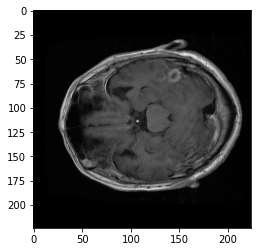

In [4]:
for image, label in validation_data_loader.take(1):
    plt.imshow(image[0].numpy().astype(np.int32))
    plt.show()

In [5]:
resnet_model = ResNet50(weights='imagenet')
for layer in resnet_model.layers:
    layer.trainable = False

i = nn.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = preprocess_input(i)
x = resnet_model(x)
x = nn.Dense(len(class_name), activation='softmax')(x)

model = tf.keras.Model(inputs = [i], outputs = [x])
model.summary()

augment = tf.keras.Sequential([nn.RandomFlip(),
	                           nn.RandomRotation(factor=1/8)
								]) #+-45



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
dense (Dense)                (None, 3)                 3003      
Total params: 25,639,715
Trainable params: 3,003
Non-trainable params: 25,636,712
_________________________________________________________________


In [6]:

loss_history = [[],[]] #[[train], [test]]
acc_history = [[],[]]
EPOCHS = 20

n_train_batches = int(0.9*total_imgs)//batch_size
n_test_batches = int(0.04*total_imgs)//batch_size
log_per_epoch = 3

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
loss_metrics = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0015, )

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'log/metrics/' + current_time + '/train'
test_log_dir = 'log/metrics/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    accuracy(labels, predictions)
    loss_metrics(labels, predictions)

@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    loss = loss_object(labels, predictions)

    accuracy(labels, predictions)
    loss_metrics(labels, predictions)


for epoch in range(EPOCHS):
    print(f"----------------EPOCH {epoch+1}---------------------------")
    with tf.device('/device:gpu:0'):
        for batch_idx , (images, labels) in  enumerate(train_data_loader):
            # images = augment(images)
            train_step(images, labels)

            loss_history[0].append(loss_metrics.result())
            acc_history[0].append(accuracy.result())

            accuracy.reset_state()
            loss_metrics.reset_state()

            if batch_idx%(n_train_batches//log_per_epoch) == 0:
                print(f"BATCH {batch_idx}/{n_train_batches} TRAIN LOSS : {loss_history[0][-1]} TRAIN ACCURACY : {acc_history[0][-1]}")

            with train_summary_writer.as_default():
                tf.summary.scalar('batch_loss', loss_history[0][-1], step=n_train_batches*epoch+batch_idx)
                tf.summary.scalar('batch_accuracy', acc_history[0][-1], step=n_train_batches*epoch+batch_idx)

        for batch_idx, (images, labels) in enumerate(validation_data_loader):
            test_step(images, labels)
            loss_history[1].append(loss_metrics.result())
            acc_history[1].append(accuracy.result())

            accuracy.reset_state()
            loss_metrics.reset_state()

    print(f"----------------EPOCH {epoch+1} STATISTICS-----------------")
    print(f"FINAL TRAIN LOSS : {loss_history[0][-1]} TRAIN ACC : {acc_history[0][-1]}")
    print(f"AVERAGE TRAIN LOSS : {sum(loss_history[0][-n_train_batches:])/n_train_batches} TRAIN ACC : {sum(acc_history[0][-n_train_batches:])/n_train_batches}")
    print(f"VAL LOSS : {sum(loss_history[1][-n_test_batches:])/n_test_batches} VAL ACC : {sum(acc_history[1][-n_test_batches:])/n_test_batches}")
    print(f"--------------------------------------------------\n")

    with train_summary_writer.as_default():
        tf.summary.scalar('loss', sum(loss_history[0][-n_train_batches:])/n_train_batches, step=epoch+1)
        tf.summary.scalar('accuracy', sum(acc_history[0][-n_train_batches:])/n_train_batches, step=epoch+1)

    with test_summary_writer.as_default():
        tf.summary.scalar('loss', sum(loss_history[1][-n_test_batches:])/n_test_batches, step=epoch+1)
        tf.summary.scalar('accuracy', sum(acc_history[1][-n_test_batches:])/n_test_batches, step=epoch+1)



----------------EPOCH 1---------------------------
BATCH 0/86 TRAIN LOSS : 1.093078851699829 TRAIN ACCURACY : 0.375
BATCH 28/86 TRAIN LOSS : 1.1055978536605835 TRAIN ACCURACY : 0.09375
BATCH 56/86 TRAIN LOSS : 1.0951544046401978 TRAIN ACCURACY : 0.3125
BATCH 84/86 TRAIN LOSS : 1.0883790254592896 TRAIN ACCURACY : 0.84375
----------------EPOCH 1 STATISTICS-----------------
FINAL TRAIN LOSS : 1.096775770187378 TRAIN ACC : 0.6000000238418579
AVERAGE TRAIN LOSS : 1.0988187789916992 TRAIN ACC : 0.330741286277771
VAL LOSS : 1.082957148551941 VAL ACC : 0.7465277314186096
--------------------------------------------------

----------------EPOCH 2---------------------------
BATCH 0/86 TRAIN LOSS : 1.1042439937591553 TRAIN ACCURACY : 0.03125
BATCH 28/86 TRAIN LOSS : 1.098541498184204 TRAIN ACCURACY : 0.375
BATCH 56/86 TRAIN LOSS : 1.0946695804595947 TRAIN ACCURACY : 0.59375
BATCH 84/86 TRAIN LOSS : 1.078221321105957 TRAIN ACCURACY : 1.0
----------------EPOCH 2 STATISTICS-----------------
FINAL TR

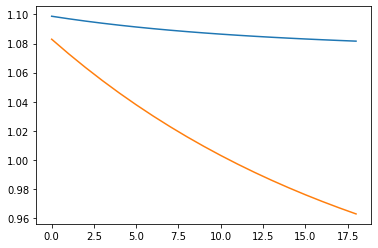

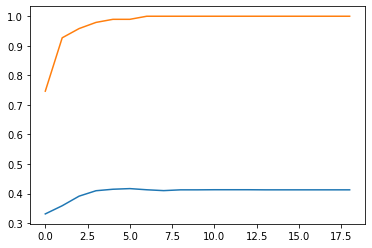

In [7]:
train_n_minibatches,n_validation_losses= tf.data.experimental.cardinality(train_data_loader).numpy(), tf.data.experimental.cardinality(validation_data_loader).numpy()
import seaborn as sns
# Plotting Loss per epoch
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    loss_per_epoch[1].append(temp/n_validation_losses)    

plt.plot(range(len(loss_per_epoch[0])),loss_per_epoch[0])
plt.plot(range(len(loss_per_epoch[1])),loss_per_epoch[1])
plt.show()



# Plotting Accuracy per epoch
accuracy_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in acc_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in acc_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    accuracy_per_epoch[1].append(temp/n_validation_losses)    

plt.plot(range(len(accuracy_per_epoch[0])),accuracy_per_epoch[0])
plt.plot(range(len(accuracy_per_epoch[1])),accuracy_per_epoch[1])
plt.show()

In [8]:
test_acc = []
test_loss = []

for images, labels in test_data_loader:
    test_step(images, labels)
    test_acc.append(accuracy.result())
    test_loss.append(loss_metrics.result())

    accuracy.reset_states()
    loss_metrics.reset_states()

print("AVERAGE TEST ACC : ",sum(test_acc)/len(test_acc))
print("AVERAGE TEST LOSS : ",sum(test_loss)/len(test_loss))

AVERAGE TEST ACC :  tf.Tensor(0.9603795, shape=(), dtype=float32)
AVERAGE TEST LOSS :  tf.Tensor(0.97001594, shape=(), dtype=float32)
